In [13]:
%matplotlib inline 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [17]:
import numpy as np
data = np.sin(np.arange(0,314/5.,0.1))

In [27]:
def init_plot_style():
    plt.style.use("seaborn-notebook")
    # future customization here
    return plt.rcParams


In [46]:
p = init_plot_style()

None


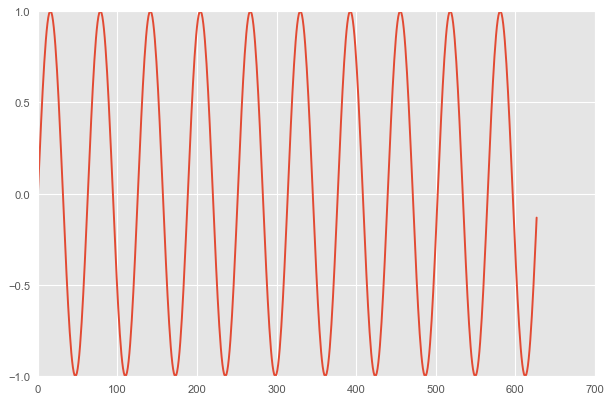

In [48]:
plt.plot(data)

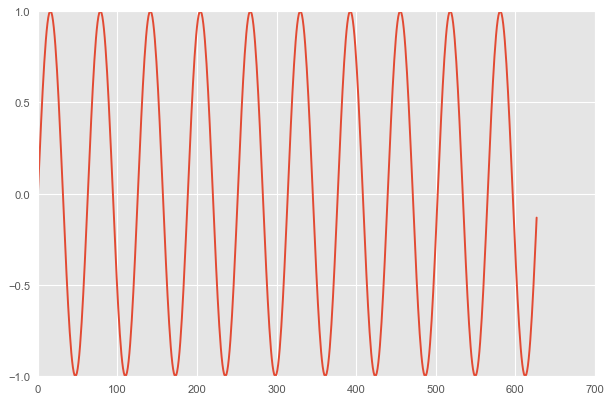

In [43]:
plt.style.use('ggplot')
plt.plot(data)